# connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup hyper-params and dataset

In [ ]:
import copy
import os
import sys
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
import torchvision.utils as vutils
import seaborn as sns
import torch.nn.init as init
import pickle
import random

In [ ]:
SEED = 0
def seed_everything(seed):
    torch.manual_seed(seed)       # Current CPU
    torch.cuda.manual_seed(seed)  # Current GPU
    np.random.seed(seed)          # Numpy module
    random.seed(seed)             # Python random module
    torch.backends.cudnn.benchmark = False    # Close optimization
    torch.backends.cudnn.deterministic = True # Close optimization
    torch.cuda.manual_seed_all(seed) # All GPU (Optional)

def stable(dataloader, seed):
    seed_everything(seed)
    return dataloader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
training_epochs = 150 # training epochs between pruning
target_p_m = 10
iterative_pruning_rounds = 10
final_sparsity = 1-target_p_m/100 # target_p_m=10, then final sparsity = 0.9
learning_rate = 0.01
SEED = 0

In [ ]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

seed_everything(SEED)
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=512, shuffle=True,)

seed_everything(SEED)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=False)

==> Preparing data..


100%|██████████| 170498071/170498071 [00:05<00:00, 29356974.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Pruning Schedules

In [ ]:
def construct_prune_schedule(total_times, final_sparsity):
    # current_sparse =  (1 - (1 - initial_ratio{usually 0} ) * (1 - current_times / total_times) ** 3) * prune_percent

    sparsity = np.zeros(total_times)
    sparsity_wrt_remaining = np.zeros(total_times)
    for i in range(total_times):
        sparsity[i] = (1-(1-(i+1)/total_times)**3)*final_sparsity
    sparsity_wrt_remaining[0] = sparsity[0]
    for i in range(1, total_times):
        sparsity_wrt_remaining[i]=(sparsity[i]-sparsity[i-1])/(1-sparsity[i-1])
    return sparsity#, sparsity_wrt_remaining

In [ ]:
def construct_one_cycle_schedule(total_times, final_sparsity):
    alpha = 14
    beta = 5
    sparsity = np.zeros(total_times)
    sparsity_remaining = np.zeros(total_times)
    for i in range(total_times):
        sparsity[i] = final_sparsity * (1+np.exp(-alpha+beta)) / (1 + (np.exp(-alpha*(i+1)/total_times+beta)))
    sparsity_remaining[0] = sparsity[0]
    for i in range(1, total_times):
        sparsity_remaining[i]=(sparsity[i]-sparsity[i-1])/(1-sparsity[i-1])
    return sparsity#, sparsity_remaining*100

In [ ]:
def pruning_schedule(schedule):
    global iterative_pruning_rounds
    global target_p_m
    global final_sparsity

    pruning_rate_per_round = np.zeros(iterative_pruning_rounds)
    if schedule=="no":
        # no pruning
        pruning_rate_per_round = np.zeros(iterative_pruning_rounds)
    elif schedule =="iterative":
        # vanilla iterative prining, how much proportion is pruned per pruning round (wrt remaining)
        # pruning_rate_per_round = np.ones(iterative_pruning_rounds) * (1-np.power(target_p_m/100, 1/iterative_pruning_rounds))*100
        to_prune = (1-np.power(target_p_m/100, 1/iterative_pruning_rounds))
        print(to_prune)
        for i in range(iterative_pruning_rounds):
            pruning_rate_per_round[i] = (1-np.power(1-to_prune,i+1))*100
    elif schedule == "adaptive":
        # Adaptive Gradual Pruning schedule
        pruning_rate_per_round = construct_prune_schedule(iterative_pruning_rounds, final_sparsity)*100
    elif schedule == "onecycle":
        # One-cycle pruning
        pruning_rate_per_round = construct_one_cycle_schedule(iterative_pruning_rounds, final_sparsity)*100
    return pruning_rate_per_round

pruning_rate_per_round_check = pruning_schedule("iterative")


0.2056717652757185


In [ ]:
pruning_rate_per_round_check

array([20.56717653, 36.90426555, 49.88127664, 60.18928294, 68.3772234 ,
       74.88113568, 80.04737685, 84.15106808, 87.41074588, 90.        ])

In [ ]:
pruning_schedule("adaptive")

array([24.39, 43.92, 59.13, 70.56, 78.75, 84.24, 87.57, 89.28, 89.91,
       90.  ])

In [ ]:
pruning_schedule("onecycle")

array([ 2.39402483,  8.97865194, 27.90574012, 58.11623879, 79.28151993,
       87.10415636, 89.27638482, 89.82880555, 89.96608323, 90.        ])

# Network - ResNet18


In [ ]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# utils

In [ ]:
def print_nonzeros(model, verbose= False):
    nonzero = total = 0
    for name, p in model.named_parameters():
        if "weight" in name:
            tensor = p.data.cpu().numpy()
            nz_count = np.count_nonzero(tensor)
            total_params = np.prod(tensor.shape)
            nonzero += nz_count
            total += total_params
            if verbose:
                print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return np.round((nonzero/total)*100,1)

In [ ]:
def weight_init(m):
    '''
    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d): #
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
        #init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d): #
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0) # bias = 0
        #init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear): #
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data) # normal
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [ ]:
def make_mask(model):
    global step
    global mask
    step = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            step = step + 1
    mask = [None]* step
    step = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            tensor = param.data.cpu().numpy()
            mask[step] = np.ones_like(tensor)
            step = step + 1
    step = 0

In [ ]:
def original_initialization(mask_temp, initial_state_dict):
    global model

    step = 0
    for name, param in model.named_parameters():
        if "weight" in name:
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        if "bias" in name:
            param.data = initial_state_dict[name]
    step = 0

In [ ]:
from torch.nn.utils import prune
def prune_by_percentile_global(percent):
    global step
    global mask
    global model

    parameters_to_prune=[]

    step = 0

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.Linear):
            #print(name+"added to prune")
            #print(hasattr(module,"weight"))
            parameters_to_prune.append((module, "weight"))
            #if hasattr(module, "weight"):
            #    parameters_to_prune.append((module, "weight"))
            #elif hasattr(module,"weight_orig"):
            #    parameters_to_prune.append((module, "weight_orig"))
    #print(parameters_to_prune)

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = percent/100
    )

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.Linear):
            prune.remove(module,"weight")

    for name, param in model.named_parameters():

        # We do not prune bias term
        if "weight" in name:
            tensor = param.data.cpu().numpy()
            #alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
            #percentile_value = np.percentile(abs(alive), percent)

            # Convert Tensors to numpy and calculate
            weight_dev = param.device
            new_mask = np.where(abs(tensor)==0, 0, mask[step])

            # Apply new weight and mask
            param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
            mask[step] = new_mask
            step += 1
    step = 0
    #for name, module in model.named_modules():
    #    if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.Linear):
    #        prune.remove(module,"weight")

In [ ]:
def checkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
def train(model, epoch, round, train_loader, optimizer, scheduler, criterion):
    EPS = 1e-6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()

    for batch_idx, (imgs, targets) in enumerate(stable(train_loader, SEED+(epoch+1)*(round+1))): # for reproducibility
        optimizer.zero_grad()
        #imgs, targets = next(train_loader)
        imgs, targets = imgs.to(device), targets.to(device)
        output = model(imgs)
        train_loss = criterion(output, targets)
        train_loss.backward()

        # Freezing Pruned weights by making their gradients Zero
        for name, p in model.named_parameters():
            if 'weight' in name:
                tensor = p.data
                grad_tensor = p.grad
                grad_tensor = torch.where(tensor.abs() < EPS, torch.zeros_like(grad_tensor), grad_tensor)
                p.grad.data = grad_tensor
        optimizer.step()
        scheduler.step()
    return train_loss.item()

In [ ]:
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, test_loss

# experiment code

In [ ]:
def main_experiment(prune_schedule="iterative", resample=False):
    global model
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150) #T_max=training_epochs
    criterion = nn.CrossEntropyLoss()

    for name, param in model.named_parameters():
        print(name, param.size())

    best_accuracy_per_round_history = np.zeros(iterative_pruning_rounds+1,float)
    best_accuracy_per_round = 0.0
    p_m = np.zeros(iterative_pruning_rounds+1,float)
    step = 0
    loss_history = np.zeros(training_epochs,float)
    accuracy_history = np.zeros(training_epochs+1,float)
    _ = print_nonzeros(model)
    pruning_rate_per_round = pruning_schedule(prune_schedule)
    #pruning_rate_per_round = np.ones(10)*9.0
    print(pruning_rate_per_round)
    # One additional round required for the original training
    for round in range(iterative_pruning_rounds+1):
        if not round == 0:
            # the calculated rate is wrt to remaining
            prune_by_percentile_global(pruning_rate_per_round[round-1])
            print("reinitialise to weight before training")
            original_initialization(mask, initial_state_dict)
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                            momentum=0.9, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150) #T_max=training_epochs

        #print(f"\n--- Pruning Level [{ITE}:{_ite}/{ITERATION}]: ---")
        print("round", round)
        p_m_current = print_nonzeros(model, verbose=True)
        p_m[round] = p_m_current
        pbar = tqdm(range(training_epochs))

        accuracy, test_loss = test(model, test_loader, criterion)
        best_accuracy_per_round = accuracy
        accuracy_history[0] = accuracy
        best_epoch = 0
        for epoch in pbar:
            loss = train(model, epoch, round, train_loader, optimizer, scheduler, criterion)
            accuracy, test_loss = test(model, test_loader, criterion)

            if accuracy > best_accuracy_per_round:
                best_accuracy_per_round = accuracy
                best_epoch = epoch
                checkdir(experiment_path+"saves/")
                torch.save(model, experiment_path+f"saves/round_{round}_best_model_lt.pth.tar")

            loss_history[epoch] = loss
            accuracy_history[epoch+1] = accuracy
            if epoch % 10 == 0:
                torch.save(model, experiment_path+f"saves/round_{round}_epoch_{epoch}_model_lt.pth.tar")
            if epoch+1==training_epochs:
                torch.save(model, experiment_path+f"saves/round_{round}_epoch_final_model_lt.pth.tar")
            pbar.set_description(
                    f'Train Epoch: {epoch}/{training_epochs} Loss: {loss:.6f} Accuracy: {accuracy:.2f}% Best Accuracy: {best_accuracy_per_round:.2f}% Best epoch: {best_epoch:.2f}')
        best_accuracy_per_round_history[round] = best_accuracy_per_round

        # Plotting Loss (Training), Accuracy (Testing) per Epoch
        plt.plot(np.arange(1,(training_epochs)+1), 100*(loss_history - np.min(loss_history))/np.ptp(loss_history).astype(float), c="blue", label="Loss")
        plt.plot(np.arange(1,(training_epochs)+1), accuracy_history[1:], c="red", label="Accuracy")
        plt.title(f"Loss and Accuracy per Epoch (ResNet18, CIFAR10)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss and Accuracy")
        plt.legend()
        plt.grid(color="gray")
        checkdir(experiment_path+"plots/")
        plt.savefig(experiment_path+f"plots/round_{round}_LossVsAccuracy_{p_m_current}.png", dpi=1200)
        plt.close()

        # Dump Plot values
        checkdir(experiment_path+"dumps/")
        loss_history.dump(experiment_path+f"dumps/round_{round}_loss_history_{p_m_current}.dat")
        accuracy_history.dump(experiment_path+f"dumps/round_{round}_accuracy_history_{p_m_current}.dat")
        with open(experiment_path+f"dumps/round_{round}_mask_{p_m_current}.pkl", 'wb') as fp:
            pickle.dump(mask, fp)

        best_accuracy = 0
        loss_history = np.zeros(training_epochs,float)
        accuracy_history = np.zeros(training_epochs+1,float)

    if iterative_pruning_rounds > 1:
        # Dumping Values for Plotting
        checkdir(experiment_path+"dumps/")
        p_m.dump(experiment_path+"dumps/compression.dat")
        best_accuracy_per_round_history.dump(experiment_path+"dumps/best_accuracy.dat")

        # Plotting
        a = np.arange(iterative_pruning_rounds+1)
        plt.plot(a, best_accuracy_per_round_history, c="blue", label="Winning tickets")
        plt.title(f"Test Accuracy vs Unpruned Weights Percentage (ResNet18, CIFAR10)")
        plt.xlabel("Unpruned Weights Percentage")
        plt.ylabel("test accuracy")
        plt.xticks(a, p_m, rotation ="vertical")
        plt.ylim(0,100)
        plt.legend()
        plt.grid(color="gray")
        checkdir(experiment_path+"plots/")
        plt.savefig(experiment_path+"plots/AccuracyVsWeights.png", dpi=1200)
        plt.close()

# save the initialised model
(already downloaded and saved to drive, completed, no need to run)

In [ ]:
#model_the_init = ResNet18().to(device)
#model_the_init.apply(weight_init)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
torch.save(model_the_init, "the_initial_model.pth.tar")

# regular

In [ ]:
# load the initial model
model = torch.load("/content/drive/MyDrive/R252/the_initial_model.pth.tar")
model.to(device)

if device == 'cuda':
    torch.backends.cudnn.benchmark = True

initial_state_dict = copy.deepcopy(model.state_dict())
experiment_path = f"original_lt_{iterative_pruning_rounds}_{target_p_m}_{training_epochs}/"
if not os.path.exists(experiment_path+"saves/"):
    os.makedirs(experiment_path+"saves/")
torch.save(model, experiment_path+"saves/initial_state_dict.pth.tar")
make_mask(model)


In [ ]:
# torchvision resnet18
main_experiment()

conv1.weight torch.Size([64, 3, 3, 3])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.shortcut.0.weight torch.Size([128, 64, 1, 1])
layer2.0.shortcut.1.weight torch.Size([128])
layer2.0.shortcut.1.bias torch.Size([128])
layer2.1.conv1.weight torch.Siz

Train Epoch: 149/150 Loss: 0.016021 Accuracy: 88.64% Best Accuracy: 90.57% Best epoch: 148.00: 100%|██████████| 150/150 [1:03:18<00:00, 25.33s/it]


reinitialise to weight before training
round 1
conv1.weight         | nonzeros =    1686 /    1728 ( 97.57%) | total_pruned =      42 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   33976 /   36864 ( 92.17%) | total_pruned =    2888 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   34079 /   36864 ( 92.45%) | total_pruned =    2785 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   33927 /   36864 ( 92.03%) | total_pruned =    2937 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   33963 /   36864 ( 92.13%) | total_pruned =    2901 | s

Train Epoch: 149/150 Loss: 0.005295 Accuracy: 88.71% Best Accuracy: 90.77% Best epoch: 145.00: 100%|██████████| 150/150 [1:03:44<00:00, 25.50s/it]


reinitialise to weight before training
round 2
conv1.weight         | nonzeros =    1599 /    1728 ( 92.53%) | total_pruned =     129 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   29907 /   36864 ( 81.13%) | total_pruned =    6957 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   29937 /   36864 ( 81.21%) | total_pruned =    6927 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   29881 /   36864 ( 81.06%) | total_pruned =    6983 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   29840 /   36864 ( 80.95%) | total_pruned =    7024 | s

Train Epoch: 149/150 Loss: 0.013831 Accuracy: 89.84% Best Accuracy: 90.58% Best epoch: 148.00: 100%|██████████| 150/150 [1:02:51<00:00, 25.15s/it]


reinitialise to weight before training
round 3
conv1.weight         | nonzeros =    1484 /    1728 ( 85.88%) | total_pruned =     244 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   26408 /   36864 ( 71.64%) | total_pruned =   10456 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   26125 /   36864 ( 70.87%) | total_pruned =   10739 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   26240 /   36864 ( 71.18%) | total_pruned =   10624 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   26489 /   36864 ( 71.86%) | total_pruned =   10375 | s

Train Epoch: 149/150 Loss: 0.004192 Accuracy: 90.02% Best Accuracy: 90.62% Best epoch: 139.00: 100%|██████████| 150/150 [1:03:48<00:00, 25.52s/it]


reinitialise to weight before training
round 4
conv1.weight         | nonzeros =    1366 /    1728 ( 79.05%) | total_pruned =     362 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   24076 /   36864 ( 65.31%) | total_pruned =   12788 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   23698 /   36864 ( 64.28%) | total_pruned =   13166 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   24064 /   36864 ( 65.28%) | total_pruned =   12800 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   24487 /   36864 ( 66.43%) | total_pruned =   12377 | s

Train Epoch: 149/150 Loss: 0.009117 Accuracy: 89.34% Best Accuracy: 90.42% Best epoch: 127.00: 100%|██████████| 150/150 [1:03:05<00:00, 25.24s/it]


reinitialise to weight before training
round 5
conv1.weight         | nonzeros =    1273 /    1728 ( 73.67%) | total_pruned =     455 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   22388 /   36864 ( 60.73%) | total_pruned =   14476 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   21908 /   36864 ( 59.43%) | total_pruned =   14956 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   22414 /   36864 ( 60.80%) | total_pruned =   14450 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   22818 /   36864 ( 61.90%) | total_pruned =   14046 | s

Train Epoch: 149/150 Loss: 0.014424 Accuracy: 88.59% Best Accuracy: 90.40% Best epoch: 120.00: 100%|██████████| 150/150 [1:03:23<00:00, 25.35s/it]


reinitialise to weight before training
round 6
conv1.weight         | nonzeros =    1208 /    1728 ( 69.91%) | total_pruned =     520 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   20951 /   36864 ( 56.83%) | total_pruned =   15913 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   20561 /   36864 ( 55.78%) | total_pruned =   16303 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   21065 /   36864 ( 57.14%) | total_pruned =   15799 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   21420 /   36864 ( 58.11%) | total_pruned =   15444 | s

Train Epoch: 149/150 Loss: 0.010653 Accuracy: 88.86% Best Accuracy: 90.22% Best epoch: 142.00: 100%|██████████| 150/150 [1:04:10<00:00, 25.67s/it]


reinitialise to weight before training
round 7
conv1.weight         | nonzeros =    1151 /    1728 ( 66.61%) | total_pruned =     577 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   19530 /   36864 ( 52.98%) | total_pruned =   17334 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   19200 /   36864 ( 52.08%) | total_pruned =   17664 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   19762 /   36864 ( 53.61%) | total_pruned =   17102 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   20045 /   36864 ( 54.38%) | total_pruned =   16819 | s

Train Epoch: 149/150 Loss: 0.005379 Accuracy: 89.10% Best Accuracy: 90.25% Best epoch: 129.00: 100%|██████████| 150/150 [1:04:34<00:00, 25.83s/it]


reinitialise to weight before training
round 8
conv1.weight         | nonzeros =    1099 /    1728 ( 63.60%) | total_pruned =     629 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   18487 /   36864 ( 50.15%) | total_pruned =   18377 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   18102 /   36864 ( 49.10%) | total_pruned =   18762 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   18556 /   36864 ( 50.34%) | total_pruned =   18308 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   18765 /   36864 ( 50.90%) | total_pruned =   18099 | s

Train Epoch: 149/150 Loss: 0.028530 Accuracy: 89.02% Best Accuracy: 90.14% Best epoch: 130.00: 100%|██████████| 150/150 [1:03:32<00:00, 25.42s/it]


reinitialise to weight before training
round 9
conv1.weight         | nonzeros =    1063 /    1728 ( 61.52%) | total_pruned =     665 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   17412 /   36864 ( 47.23%) | total_pruned =   19452 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   16971 /   36864 ( 46.04%) | total_pruned =   19893 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   17390 /   36864 ( 47.17%) | total_pruned =   19474 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   17603 /   36864 ( 47.75%) | total_pruned =   19261 | s

Train Epoch: 149/150 Loss: 0.013727 Accuracy: 88.31% Best Accuracy: 90.43% Best epoch: 132.00: 100%|██████████| 150/150 [1:03:23<00:00, 25.36s/it]


reinitialise to weight before training
round 10
conv1.weight         | nonzeros =    1033 /    1728 ( 59.78%) | total_pruned =     695 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16362 /   36864 ( 44.38%) | total_pruned =   20502 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15932 /   36864 ( 43.22%) | total_pruned =   20932 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16349 /   36864 ( 44.35%) | total_pruned =   20515 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16450 /   36864 ( 44.62%) | total_pruned =   20414 | 

Train Epoch: 149/150 Loss: 0.014018 Accuracy: 88.94% Best Accuracy: 90.33% Best epoch: 145.00: 100%|██████████| 150/150 [1:03:16<00:00, 25.31s/it]


In [ ]:
!mkdir /content/drive/MyDrive/R252/LT_global_0314
!cp -r original_lt_10_10_150 /content/drive/MyDrive/R252/LT_global_0314

# agp

In [ ]:
model = torch.load("/content/drive/MyDrive/R252/the_initial_model.pth.tar")
model.to(device)

if device == 'cuda':
    torch.backends.cudnn.benchmark = True

initial_state_dict = copy.deepcopy(model.state_dict())
experiment_path = f"adaptive_lt_{iterative_pruning_rounds}_{target_p_m}_{training_epochs}/"
if not os.path.exists(experiment_path+"saves/"):
    os.makedirs(experiment_path+"saves/")
torch.save(model, experiment_path+"saves/initial_state_dict.pth.tar")
make_mask(model)

In [ ]:
# torchvision resnet18
main_experiment(prune_schedule="adaptive")

conv1.weight torch.Size([64, 3, 3, 3])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.shortcut.0.weight torch.Size([128, 64, 1, 1])
layer2.0.shortcut.1.weight torch.Size([128])
layer2.0.shortcut.1.bias torch.Size([128])
layer2.1.conv1.weight torch.Siz

Train Epoch: 149/150 Loss: 0.016021 Accuracy: 88.64% Best Accuracy: 90.57% Best epoch: 148.00: 100%|██████████| 150/150 [1:04:00<00:00, 25.60s/it]


reinitialise to weight before training
round 1
conv1.weight         | nonzeros =    1680 /    1728 ( 97.22%) | total_pruned =      48 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   33444 /   36864 ( 90.72%) | total_pruned =    3420 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   33536 /   36864 ( 90.97%) | total_pruned =    3328 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   33383 /   36864 ( 90.56%) | total_pruned =    3481 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   33402 /   36864 ( 90.61%) | total_pruned =    3462 | s

Train Epoch: 149/150 Loss: 0.008461 Accuracy: 89.12% Best Accuracy: 90.68% Best epoch: 145.00: 100%|██████████| 150/150 [1:04:47<00:00, 25.92s/it]


reinitialise to weight before training
round 2
conv1.weight         | nonzeros =    1572 /    1728 ( 90.97%) | total_pruned =     156 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   28781 /   36864 ( 78.07%) | total_pruned =    8083 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   28735 /   36864 ( 77.95%) | total_pruned =    8129 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   28567 /   36864 ( 77.49%) | total_pruned =    8297 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   28707 /   36864 ( 77.87%) | total_pruned =    8157 | s

Train Epoch: 149/150 Loss: 0.010453 Accuracy: 90.07% Best Accuracy: 90.75% Best epoch: 148.00: 100%|██████████| 150/150 [1:04:05<00:00, 25.63s/it]


reinitialise to weight before training
round 3
conv1.weight         | nonzeros =    1432 /    1728 ( 82.87%) | total_pruned =     296 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   24943 /   36864 ( 67.66%) | total_pruned =   11921 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   24739 /   36864 ( 67.11%) | total_pruned =   12125 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   24920 /   36864 ( 67.60%) | total_pruned =   11944 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   25184 /   36864 ( 68.32%) | total_pruned =   11680 | s

Train Epoch: 149/150 Loss: 0.017631 Accuracy: 88.86% Best Accuracy: 90.54% Best epoch: 99.00: 100%|██████████| 150/150 [1:02:33<00:00, 25.02s/it]


reinitialise to weight before training
round 4
conv1.weight         | nonzeros =    1321 /    1728 ( 76.45%) | total_pruned =     407 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   22390 /   36864 ( 60.74%) | total_pruned =   14474 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   22188 /   36864 ( 60.19%) | total_pruned =   14676 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   22421 /   36864 ( 60.82%) | total_pruned =   14443 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   22859 /   36864 ( 62.01%) | total_pruned =   14005 | s

Train Epoch: 149/150 Loss: 0.020926 Accuracy: 89.59% Best Accuracy: 90.56% Best epoch: 130.00: 100%|██████████| 150/150 [1:02:54<00:00, 25.17s/it]


reinitialise to weight before training
round 5
conv1.weight         | nonzeros =    1229 /    1728 ( 71.12%) | total_pruned =     499 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   20421 /   36864 ( 55.40%) | total_pruned =   16443 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   20154 /   36864 ( 54.67%) | total_pruned =   16710 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   20490 /   36864 ( 55.58%) | total_pruned =   16374 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   20873 /   36864 ( 56.62%) | total_pruned =   15991 | s

Train Epoch: 149/150 Loss: 0.006624 Accuracy: 88.21% Best Accuracy: 90.31% Best epoch: 144.00: 100%|██████████| 150/150 [1:04:39<00:00, 25.86s/it]


reinitialise to weight before training
round 6
conv1.weight         | nonzeros =    1177 /    1728 ( 68.11%) | total_pruned =     551 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   18903 /   36864 ( 51.28%) | total_pruned =   17961 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   18521 /   36864 ( 50.24%) | total_pruned =   18343 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   18812 /   36864 ( 51.03%) | total_pruned =   18052 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   19137 /   36864 ( 51.91%) | total_pruned =   17727 | s

Train Epoch: 149/150 Loss: 0.013598 Accuracy: 88.54% Best Accuracy: 90.25% Best epoch: 93.00: 100%|██████████| 150/150 [1:05:20<00:00, 26.13s/it]


reinitialise to weight before training
round 7
conv1.weight         | nonzeros =    1138 /    1728 ( 65.86%) | total_pruned =     590 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   17715 /   36864 ( 48.06%) | total_pruned =   19149 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   17176 /   36864 ( 46.59%) | total_pruned =   19688 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   17568 /   36864 ( 47.66%) | total_pruned =   19296 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   17787 /   36864 ( 48.25%) | total_pruned =   19077 | s

Train Epoch: 149/150 Loss: 0.010526 Accuracy: 89.26% Best Accuracy: 90.41% Best epoch: 139.00: 100%|██████████| 150/150 [1:04:17<00:00, 25.71s/it]


reinitialise to weight before training
round 8
conv1.weight         | nonzeros =    1109 /    1728 ( 64.18%) | total_pruned =     619 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16910 /   36864 ( 45.87%) | total_pruned =   19954 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   16304 /   36864 ( 44.23%) | total_pruned =   20560 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16704 /   36864 ( 45.31%) | total_pruned =   20160 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16852 /   36864 ( 45.71%) | total_pruned =   20012 | s

Train Epoch: 149/150 Loss: 0.007235 Accuracy: 88.82% Best Accuracy: 90.28% Best epoch: 96.00: 100%|██████████| 150/150 [1:03:57<00:00, 25.58s/it]


reinitialise to weight before training
round 9
conv1.weight         | nonzeros =    1078 /    1728 ( 62.38%) | total_pruned =     650 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16350 /   36864 ( 44.35%) | total_pruned =   20514 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15768 /   36864 ( 42.77%) | total_pruned =   21096 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16187 /   36864 ( 43.91%) | total_pruned =   20677 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16305 /   36864 ( 44.23%) | total_pruned =   20559 | s

Train Epoch: 149/150 Loss: 0.010194 Accuracy: 87.97% Best Accuracy: 90.17% Best epoch: 130.00: 100%|██████████| 150/150 [1:02:37<00:00, 25.05s/it]


reinitialise to weight before training
round 10
conv1.weight         | nonzeros =    1064 /    1728 ( 61.57%) | total_pruned =     664 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16240 /   36864 ( 44.05%) | total_pruned =   20624 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15662 /   36864 ( 42.49%) | total_pruned =   21202 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16087 /   36864 ( 43.64%) | total_pruned =   20777 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16208 /   36864 ( 43.97%) | total_pruned =   20656 | 

Train Epoch: 149/150 Loss: 0.023474 Accuracy: 89.42% Best Accuracy: 90.26% Best epoch: 148.00: 100%|██████████| 150/150 [1:03:33<00:00, 25.43s/it]


In [ ]:
!cp -r /content/adaptive_lt_10_10_150 /content/drive/MyDrive/R252/LT_global_0314

# onecycle

In [ ]:
model = torch.load("/content/drive/MyDrive/R252/the_initial_model.pth.tar")
model.to(device)

if device == 'cuda':
    torch.backends.cudnn.benchmark = True

initial_state_dict = copy.deepcopy(model.state_dict())
experiment_path = f"onecycle_lt_{iterative_pruning_rounds}_{target_p_m}_{training_epochs}/"
if not os.path.exists(experiment_path+"saves/"):
    os.makedirs(experiment_path+"saves/")
torch.save(model, experiment_path+"saves/initial_state_dict.pth.tar")
make_mask(model)

In [ ]:
# torchvision resnet18
main_experiment(prune_schedule="onecycle")

conv1.weight torch.Size([64, 3, 3, 3])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.shortcut.0.weight torch.Size([128, 64, 1, 1])
layer2.0.shortcut.1.weight torch.Size([128])
layer2.0.shortcut.1.bias torch.Size([128])
layer2.1.conv1.weight torch.Siz

Train Epoch: 149/150 Loss: 0.016021 Accuracy: 88.64% Best Accuracy: 90.57% Best epoch: 148.00: 100%|██████████| 150/150 [58:12<00:00, 23.28s/it]


reinitialise to weight before training
round 1
conv1.weight         | nonzeros =    1722 /    1728 ( 99.65%) | total_pruned =       6 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   36572 /   36864 ( 99.21%) | total_pruned =     292 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   36580 /   36864 ( 99.23%) | total_pruned =     284 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   36587 /   36864 ( 99.25%) | total_pruned =     277 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   36550 /   36864 ( 99.15%) | total_pruned =     314 | s

Train Epoch: 149/150 Loss: 0.050632 Accuracy: 89.41% Best Accuracy: 90.66% Best epoch: 145.00: 100%|██████████| 150/150 [57:49<00:00, 23.13s/it]


reinitialise to weight before training
round 2
conv1.weight         | nonzeros =    1702 /    1728 ( 98.50%) | total_pruned =      26 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   35626 /   36864 ( 96.64%) | total_pruned =    1238 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   35574 /   36864 ( 96.50%) | total_pruned =    1290 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   35576 /   36864 ( 96.51%) | total_pruned =    1288 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   35574 /   36864 ( 96.50%) | total_pruned =    1290 | s

Train Epoch: 149/150 Loss: 0.024611 Accuracy: 88.51% Best Accuracy: 90.69% Best epoch: 148.00: 100%|██████████| 150/150 [57:26<00:00, 22.98s/it]


reinitialise to weight before training
round 3
conv1.weight         | nonzeros =    1632 /    1728 ( 94.44%) | total_pruned =      96 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   32409 /   36864 ( 87.92%) | total_pruned =    4455 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   32329 /   36864 ( 87.70%) | total_pruned =    4535 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   32258 /   36864 ( 87.51%) | total_pruned =    4606 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   32161 /   36864 ( 87.24%) | total_pruned =    4703 | s

Train Epoch: 149/150 Loss: 0.018743 Accuracy: 89.32% Best Accuracy: 90.73% Best epoch: 148.00: 100%|██████████| 150/150 [56:54<00:00, 22.76s/it]


reinitialise to weight before training
round 4
conv1.weight         | nonzeros =    1458 /    1728 ( 84.38%) | total_pruned =     270 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   26215 /   36864 ( 71.11%) | total_pruned =   10649 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   25887 /   36864 ( 70.22%) | total_pruned =   10977 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   25874 /   36864 ( 70.19%) | total_pruned =   10990 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   25949 /   36864 ( 70.39%) | total_pruned =   10915 | s

Train Epoch: 149/150 Loss: 0.016825 Accuracy: 89.47% Best Accuracy: 90.51% Best epoch: 139.00: 100%|██████████| 150/150 [57:35<00:00, 23.03s/it]


reinitialise to weight before training
round 5
conv1.weight         | nonzeros =    1258 /    1728 ( 72.80%) | total_pruned =     470 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   21124 /   36864 ( 57.30%) | total_pruned =   15740 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   20744 /   36864 ( 56.27%) | total_pruned =   16120 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   20976 /   36864 ( 56.90%) | total_pruned =   15888 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   21153 /   36864 ( 57.38%) | total_pruned =   15711 | s

Train Epoch: 149/150 Loss: 0.007884 Accuracy: 88.78% Best Accuracy: 90.13% Best epoch: 123.00: 100%|██████████| 150/150 [57:56<00:00, 23.18s/it]


reinitialise to weight before training
round 6
conv1.weight         | nonzeros =    1140 /    1728 ( 65.97%) | total_pruned =     588 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   18195 /   36864 ( 49.36%) | total_pruned =   18669 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   17710 /   36864 ( 48.04%) | total_pruned =   19154 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   18065 /   36864 ( 49.00%) | total_pruned =   18799 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   18126 /   36864 ( 49.17%) | total_pruned =   18738 | s

Train Epoch: 149/150 Loss: 0.014357 Accuracy: 89.28% Best Accuracy: 90.06% Best epoch: 127.00: 100%|██████████| 150/150 [57:52<00:00, 23.15s/it]


reinitialise to weight before training
round 7
conv1.weight         | nonzeros =    1077 /    1728 ( 62.33%) | total_pruned =     651 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16974 /   36864 ( 46.04%) | total_pruned =   19890 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   16399 /   36864 ( 44.49%) | total_pruned =   20465 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16866 /   36864 ( 45.75%) | total_pruned =   19998 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16875 /   36864 ( 45.78%) | total_pruned =   19989 | s

Train Epoch: 149/150 Loss: 0.009507 Accuracy: 88.84% Best Accuracy: 90.21% Best epoch: 135.00: 100%|██████████| 150/150 [57:15<00:00, 22.91s/it]


reinitialise to weight before training
round 8
conv1.weight         | nonzeros =    1058 /    1728 ( 61.23%) | total_pruned =     670 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16541 /   36864 ( 44.87%) | total_pruned =   20323 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15875 /   36864 ( 43.06%) | total_pruned =   20989 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16425 /   36864 ( 44.56%) | total_pruned =   20439 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16446 /   36864 ( 44.61%) | total_pruned =   20418 | s

Train Epoch: 149/150 Loss: 0.014804 Accuracy: 89.20% Best Accuracy: 90.15% Best epoch: 148.00: 100%|██████████| 150/150 [57:35<00:00, 23.04s/it]


reinitialise to weight before training
round 9
conv1.weight         | nonzeros =    1045 /    1728 ( 60.47%) | total_pruned =     683 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16385 /   36864 ( 44.45%) | total_pruned =   20479 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15713 /   36864 ( 42.62%) | total_pruned =   21151 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16274 /   36864 ( 44.15%) | total_pruned =   20590 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16295 /   36864 ( 44.20%) | total_pruned =   20569 | s

Train Epoch: 149/150 Loss: 0.007819 Accuracy: 89.26% Best Accuracy: 90.20% Best epoch: 148.00: 100%|██████████| 150/150 [57:51<00:00, 23.14s/it]


reinitialise to weight before training
round 10
conv1.weight         | nonzeros =    1036 /    1728 ( 59.95%) | total_pruned =     692 | shape = (64, 3, 3, 3)
bn1.weight           | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv1.weight | nonzeros =   16327 /   36864 ( 44.29%) | total_pruned =   20537 | shape = (64, 64, 3, 3)
layer1.0.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.0.conv2.weight | nonzeros =   15647 /   36864 ( 42.45%) | total_pruned =   21217 | shape = (64, 64, 3, 3)
layer1.0.bn2.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv1.weight | nonzeros =   16243 /   36864 ( 44.06%) | total_pruned =   20621 | shape = (64, 64, 3, 3)
layer1.1.bn1.weight  | nonzeros =      64 /      64 (100.00%) | total_pruned =       0 | shape = (64,)
layer1.1.conv2.weight | nonzeros =   16250 /   36864 ( 44.08%) | total_pruned =   20614 | 

Train Epoch: 149/150 Loss: 0.025170 Accuracy: 89.10% Best Accuracy: 89.98% Best epoch: 147.00: 100%|██████████| 150/150 [57:39<00:00, 23.07s/it]


In [ ]:
!cp -r /content/onecycle_lt_10_10_150 /content/drive/MyDrive/R252/LT_global_0314

# plots

In [ ]:
original = [0]+pruning_rate_per_round_check.tolist()

In [ ]:
agp = [0]+pruning_schedule("adaptive").tolist()

In [ ]:
onecycle = [0]+pruning_schedule("onecycle").tolist()

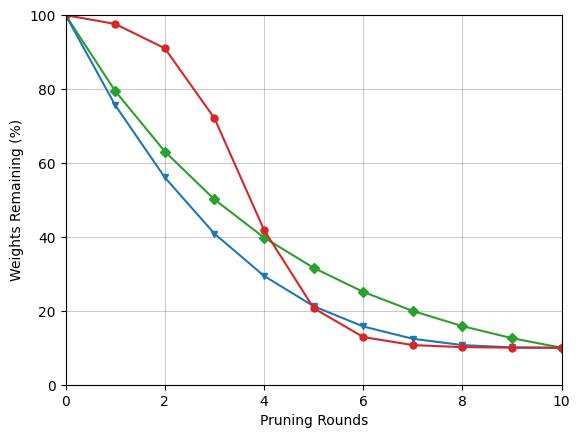

In [ ]:

plt.plot(np.arange(0,11,1), 100-np.array(original),"tab:green", marker='D', markersize=5, label="Original")
plt.plot(np.arange(0,11,1), 100-np.array(agp),"tab:blue", marker='v', markersize=5, label="Adapted AGP")
plt.plot(np.arange(0,11,1), 100-np.array(onecycle),"tab:red", marker='o', markersize=5, label="Adapted OCP")

#plt.legend()
plt.xlim((0,10))
#plt.xticks(np.arange(0,91,10))
plt.ylim((0,100))
plt.xlabel("Pruning Rounds")
plt.ylabel("Weights Remaining (%)")
plt.grid(color='k', linestyle='-', alpha=0.2)
plt.savefig("Schedule_Weights_Remaining.pdf", format="pdf", bbox_inches="tight")

plt.show()

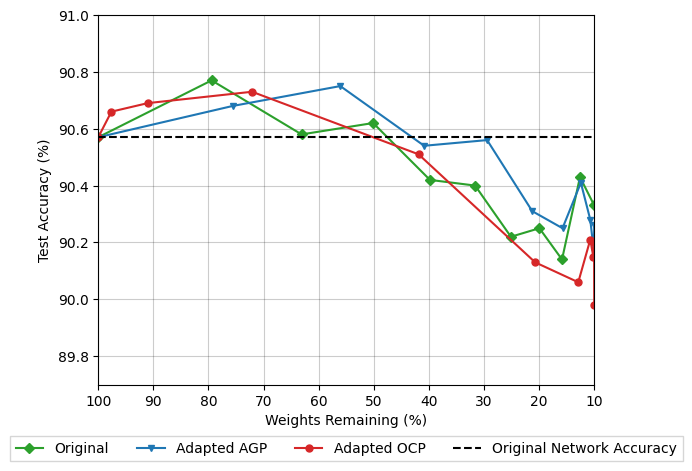

In [ ]:
original_sparsity = [
    0.00, 20.57, 36.90, 49.88, 60.19, 68.38, 74.88, 80.05, 84.15, 87.41, 90.00
]

agp_sparsity = [
    0.00, 24.39, 43.92, 59.13, 70.56, 78.75, 84.24, 87.57, 89.28, 89.91, 90.00
]

onecycle_sparsity = [
    0.00, 2.39, 8.98, 27.91, 58.12, 79.28, 87.10, 89.28, 89.83, 89.97, 90.00
]



original_remaining = 100-np.array(original_sparsity)
agp_remaining = 100-np.array(agp_sparsity)
onecycle_remaining = 100-np.array(onecycle_sparsity)
global_original_accuracy = np.load("/content/drive/MyDrive/R252/LT_global_0314/original_lt_10_10_150_for_experiment/dumps/best_accuracy.dat",allow_pickle=True)
global_agp_accuracy = np.load("/content/drive/MyDrive/R252/LT_global_0314/adaptive_lt_10_10_150_for_experiment/dumps/best_accuracy.dat",allow_pickle=True)
global_onecycle_accuracy = np.load("/content/drive/MyDrive/R252/LT_global_0314/onecycle_lt_10_10_150_for_experiment/dumps/best_accuracy.dat",allow_pickle=True)
plt.plot(original_remaining, global_original_accuracy,"tab:green", marker='D', markersize=5, label="Original")
plt.plot(agp_remaining, global_agp_accuracy,"tab:blue", marker='v', markersize=5, label="Adapted AGP")
plt.plot(onecycle_remaining, global_onecycle_accuracy,"tab:red", marker='o', markersize=5, label="Adapted OCP")
plt.plot(np.arange(100,0,-10),np.ones(10)*90.57, linestyle="--",color="k", label = "Original Network Accuracy")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=5,fancybox=False, shadow=False)

plt.xticks(np.arange(100,9,-10))
plt.ylim((89.7,91))
plt.xlabel("Weights Remaining (%)")
plt.ylabel("Test Accuracy (%)")
plt.gca().invert_xaxis()
plt.xlim((100,10))
plt.grid(color='k', linestyle='-', alpha=0.2)
plt.savefig("Schedule_Accuracy_Sparsity.png.pdf", format="pdf", bbox_inches="tight")
plt.show()
